In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as spo

In [2]:
%matplotlib inline

In [3]:
def f(X):
    Y = (X - 1.5)**2 + 0.5
    print("X = {}, Y = {}".format(X,Y))
    return Y

In [4]:
#Xguess = 2.0
#min_result = spo.minimize(f, Xguess, method='SLSQP', options={'disp':True})

In [5]:
# print("Minima found at:")
# print("X = {}, Y = {}".format(min_result.x, min_result.fun))

In [6]:
# Xplot = np.linspace(0.5,2.5,21)
# Yplot = f(Xplot)
# plt.plot(Xplot, Yplot)
# plt.plot(min_result.x, min_result.fun, 'ro')
# plt.title("Minima of an objective function")
# plt.show()

## Fit Squared error

In [7]:
def error(line, data):
    err = np.sum((data[:,1] - (line[0]*data[:, 0] + line[1]))**2)
    return err

In [8]:
l_orig = np.float32([4,2])
print("Original line: C0 = {}, C1 = {} ".format(l_orig[0], l_orig[1]))
Xorig = np.linspace(0,10,21)
Yorig = l_orig[0]*Xorig + l_orig[1]

Original line: C0 = 4.0, C1 = 2.0 


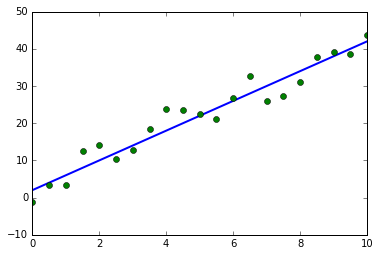

In [9]:
plt.plot(Xorig, Yorig, 'b',linewidth=2.0, label="Original Line")

##Generate noisy data
noise_sigma = 3.0
noise = np.random.normal(0,noise_sigma, Yorig.shape)
data = np.asarray([Xorig, Yorig + noise]).T
plt.plot(data[:, 0], data[:,1], 'go', label="Data Points")

In [10]:
def fit_line(data, error_func):
    
    # Generate random gess
    l = np.float32([0, np.mean(data[:, 1])]) # slope=0, intercept=mean(yvalue)
    
    # Plot initial guess
    x_ends = np.float32([-5,5])
    plt.plot(x_ends, l[0]*x_ends + l[1], 'm--', linewidth=2.0, label="Initial Guess")
    
    # Call oprimizer
    result = spo.minimize(error_func, l, args=(data,), method='SLSQP', options={'disp':True})
    return result.x

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 193.25120595
            Iterations: 5
            Function evaluations: 24
            Gradient evaluations: 5
Fitted line: C0 = 3.930858522460988, C1 = 2.612966069289857


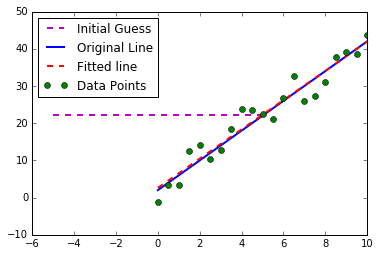

In [11]:
## Try to fit a lnine to this data
l_fit = fit_line(data, error)
print("Fitted line: C0 = {}, C1 = {}".format(l_fit[0], l_fit[1]))
plt.plot(Xorig, Yorig, 'b',linewidth=2.0, label="Original Line")
plt.plot(data[:,0], l_fit[0]*data[:, 0] + l_fit[1], 'r--', linewidth=2.0, label="Fitted line")
plt.plot(data[:, 0], data[:,1], 'go', label="Data Points")
plt.legend(loc="upper left")
plt.show()

## Non linear optimizer

In [12]:
def error_poly(C, data):
    # Metric: Sum of squared Y-axis differences
    
    err = np.sum((data[:, 1] - np.polyval(C, data[:, 0]))**2)
    return err

In [13]:
def fit_poly(data, error_func, degree=3):
    Cguess = np.poly1d(np.ones(degree+1, dtype=np.float32))
    x = np.linspace(-5,5,21)
    plt.plot(x, np.polyval(Cguess,x), 'm--',linewidt=2.0, label="Initial Guess")
    
    result = spo.minimize(error_func, Cguess, args=(data,), method='SLSQP', options={'disp':True})
    return np.poly1d(result.x)

# Portfolio Analysis

In [14]:
def get_data(symbols, dates):
    comp_symbols = symbols.copy()
    df_new = pd.DataFrame(index=dates)
    if "SPY" not in symbols:
        comp_symbols.insert(0,"SPY")
    for symbol in comp_symbols:
        df_temp = pd.read_csv("../data/stocks/{}.csv".format(symbol), index_col='Date',\
                             parse_dates=True, usecols=['Date', 'Adj Close'])
        df_temp = df_temp.rename(columns={'Adj Close': symbol})
        df_new = df_new.join(df_temp)
        if symbol == "SPY":
            df_new = df_new.dropna()
    return df_new

In [15]:
def plot_data(df, title="Stock Prices", ylabel=None):
    if ylabel is None:
        ylabel = "Price"
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel("Date")
    ax.set_ylabel(ylabel)
    plt.show()

In [16]:
def get_portfolio_values(prices, allocs, start_val=1):
    normed = prices / prices.ix[0]
    
    portfolio_returns = (normed*allocs).sum(axis=1)
    port_val = portfolio_returns*start_val
    
    return port_val

In [17]:
def get_portfolio_stats(port_val, daily_rf=0, samples_per_year=252):
    daily_ret = (port_val[1:].values/port_val[:-1].values) -1
    #daily_ret = daily_ret[1:]  # no need for this nan is not included in this
    port_val = pd.DataFrame(port_val)
    cum_ret = np.array(port_val.ix[-1].values/port_val.ix[0].values - 1.0)
    
    avg_daily_ret = daily_ret.mean()
    
    std_daily_ret = daily_ret.std()
    
    sharpe_ratio = np.sqrt(samples_per_year) * daily_ret.mean()/daily_ret.std()
    
    return cum_ret, avg_daily_ret, std_daily_ret, sharpe_ratio

In [18]:
def assess_portfolio(data, symbols,  allocs, start_val=1):
    prices = data[symbols]
    prices_SPY = data['SPY']   #For comparison
    
    port_val = get_portfolio_values(prices, allocs, start_val)
    port_val = pd.DataFrame(port_val)
    #print(port_val)
    samples_per_year=252
    cum_ret, avg_daily_ret, std_daily_ret, sharpe_ratio = \
    get_portfolio_stats(port_val, samples_per_year)
    
    print("Start Date: ", start_date)
    print("End Date: ", end_date)
    print("Symbols: ", symbols)
    print("Allocations: ", allocs)
    print("Sharpe Ratio: ", sharpe_ratio)
    print("Volatility (stdev of daily returns):", std_daily_ret)
    print("Volatility (stdev of daily returns, annualized):", std_daily_ret * np.sqrt(samples_per_year))
    print("Average Daily Return:", avg_daily_ret)
    print("Cumulative Return:", cum_ret)

In [19]:
start_date = '2010-01-01'
end_date = '2010-12-31'

#symbols = ['GOOG', 'AAPL', 'GLD', 'XOM']
symbol_allocations = {'GLD':0.4, 'XOM': 0.1, 'GOOG': 0.2, 'AAPL': 0.3}
symbols = list(symbol_allocations.keys())
allocs = list(symbol_allocations.values())
start_val = 1000000


dates = pd.date_range(start_date, end_date)
df = get_data(symbols, dates)

In [20]:
#pd.DataFrame(df[-1]/df[0] -1.0).head()

In [21]:
assess_portfolio(df, symbols, allocs, start_val)

Start Date:  2010-01-01
End Date:  2010-12-31
Symbols:  ['GOOG', 'AAPL', 'XOM', 'GLD']
Allocations:  [0.2, 0.3, 0.1, 0.4]
Sharpe Ratio:  1.52122579096
Volatility (stdev of daily returns): 0.00999044185732
Volatility (stdev of daily returns, annualized): 0.158593347853
Average Daily Return: 0.000957366234238
Cumulative Return: [ 0.25564678]


# Portfolio Optimizer

In [22]:
def sharpe_maximizer(allocs, prices):
    
    port_val = get_portfolio_values(prices, allocs)
    samples_per_year = 252
    cum_ret, avg_daily_ret, std_daily_ret, sharpe_ratio = \
    get_portfolio_stats(port_val, samples_per_year)
    
    return sharpe_ratio*-1

In [23]:
def find_optimal_allocation(prices):
    
    guess = np.ones(prices.shape[1], dtype=np.float64)*1.0/prices.shape[1]
    alloc_bounds = [(0, 1)]*prices.shape[1]
    
    alloc_constraints = ({'type':'eq','fun': lambda x: np.sum(x)-1})
    min_result = spo.minimize(sharpe_maximizer, guess, args=(prices, ),\
                             method="SLSQP", options={'disp':True},\
                             bounds = alloc_bounds, constraints=alloc_constraints)
    #print(min_result)
    return min_result.x

In [87]:
def optimize_portfolio(data, symbols, start_val):
    prices = data[symbols]
    prices_SPY = data['SPY']
    
    opt_allocs = find_optimal_allocation(prices)
    opt_allocs = opt_allocs / np.sum(opt_allocs) ## Normalize allocsations, if they dont sum to 1.0
    #print("<----------Optimum Allocations--------------->")
    #print(opt_allocs)
    assess_portfolio(data, symbols, opt_allocs, start_val)
    return opt_allocs

In [88]:
optimum_allocs = optimize_portfolio(df, symbols, start_val)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2.00801904073
            Iterations: 6
            Function evaluations: 36
            Gradient evaluations: 6
Start Date:  2010-01-01
End Date:  2010-12-31
Symbols:  ['GOOG', 'AAPL', 'XOM', 'GLD']
Allocations:  [  0.00000000e+00   3.96660601e-01   1.87808195e-16   6.03339399e-01]
Sharpe Ratio:  2.00801904073
Volatility (stdev of daily returns): 0.0100962041463
Volatility (stdev of daily returns, annualized): 0.16027227214
Average Daily Return: 0.00127710227841
Cumulative Return: [ 0.36009056]


In [89]:
optimum_allocs

array([  0.00000000e+00,   3.96660601e-01,   1.87808195e-16,
         6.03339399e-01])

In [128]:
def plot_data(data, symbols, regular_allocs, optimal_allocs, start_val):
    prices = data[symbols]
    normed_prices = prices/prices.ix[0]
    not_opt_return = normed_prices * regular_allocs
    pos_values = not_opt_return * start_val
    not_opt_portfolio_vals = pd.DataFrame(pos_values.sum(axis=1)/pos_values.ix[0], index=data.index, columns=['sum'])
    #plt.plot(not_opt_portfolio_vals.index, not_opt_portfolio_vals['sum'], label="Non Optimized Portfolio")
    plt.plot(data.index, data['SPY']/data['SPY'].ix[0], label="SPY")
    
    opt_allocated = normed_prices * optimal_allocs
    #print(opt_allocated.head())
    opt_pos_values = opt_allocated * start_val
    opt_portfolio_values = pd.DataFrame(opt_pos_values.sum(axis=1), index=data.index, columns=['sum'])
    plt.plot(opt_portfolio_values.index, opt_portfolio_values['sum']/opt_portfolio_values['sum'].ix[0], label="Optimized Portfolio")
    plt.xticks(rotation=40)
    plt.legend(loc='upper left')

C:\Users\Kunal\Anaconda3\lib\site-packages\pandas\indexes\base.py:2397: RuntimeWarning: Cannot compare type 'Timestamp' with type 'str', sort order is undefined for incomparable objects
  return this.join(other, how=how, return_indexers=return_indexers)


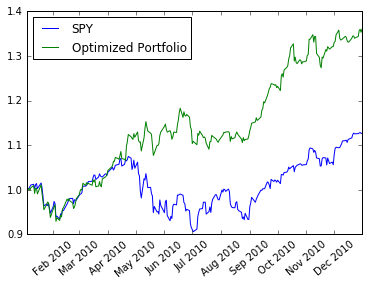

In [129]:
plot_data(df, symbols, allocs, optimum_allocs, start_val)